<a href="https://colab.research.google.com/github/danielturg/Road2_AI_Course_Scripts/blob/main/HW6_Road2_AI_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

write a code to build a convolutional neural that receives an image and classifies it as either a dog or a cat. get 3000 total images from the dataset: 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' , where 2000 are put in train (1000 cats and 1000 dogs) and 1000 in validation. in preprocessing i want you to resize the images to 150 by 150 (the images are not a constants resolution). keep them in color. i want the structure of the network to be as follows: sequential, layers as follows: conv2d(32,(3,3),relu,input_shape = (150,150,3)), maxpooling2d(2,2), then conv2d(64, (3,3)) then another maxpooling, then conv2d of 128 then another maxpooling, then another conv 128 then max pooling, then flatten, then dense 512 relu, then dense 2 softmax.i want you to also show the confusion matrix at the end and show the accuracy while learning.

--2023-12-11 14:59:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 142.251.31.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  30.1MB/s    in 2.2s    

2023-12-11 15:00:01 (30.1 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 27s 166ms/step - loss: 0.7022 - accuracy: 0.5010 - val_loss: 0.6927 - val_accuracy: 0.5400
Epoch 2/100
100/100 [==============================] - 16s 163ms/step - loss: 0.6946 - accuracy: 0.5145 - val_loss: 0.6931 - val_accuracy: 0.5

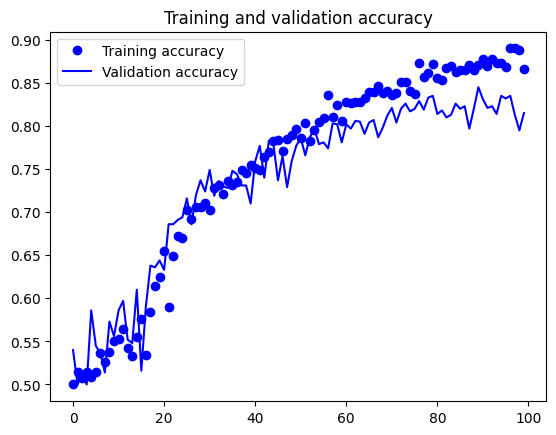

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Download and extract the dataset
zip_path = '/content/cats_and_dogs_filtered.zip'
!wget --no-check-certificate \
    'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' \
    -O $zip_path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Define paths
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Set up data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 images = batch_size * steps
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50  # 1000 images = batch_size * steps
)

# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Display the confusion matrix
validation_steps = len(validation_generator)
Y_pred = model.predict(validation_generator, validation_steps)
y_pred = np.argmax(Y_pred, axis=1)

conf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Show the plot
plt.show()


prediction

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import requests
from PIL import Image
from io import BytesIO


# Function to load and preprocess an image from a URL
def load_and_preprocess_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Define the URL of the image you want to test
image_url = 'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*'

# Load and preprocess the image
test_image = load_and_preprocess_image(image_url)

# Make a prediction
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)

# Define class labels
class_labels = ['cat', 'dog']

# Print the prediction
print("Predicted class:", class_labels[predicted_class])


1/1 [==============================] - 0s 205ms/step
Predicted class: dog
